# Implementing Bayesian Linear Regression: A Comparative Analysis against OLS and Application in Probabilistic Sales Forecasting

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [63]:
df = pd.read_csv('advertising.csv')

In [64]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


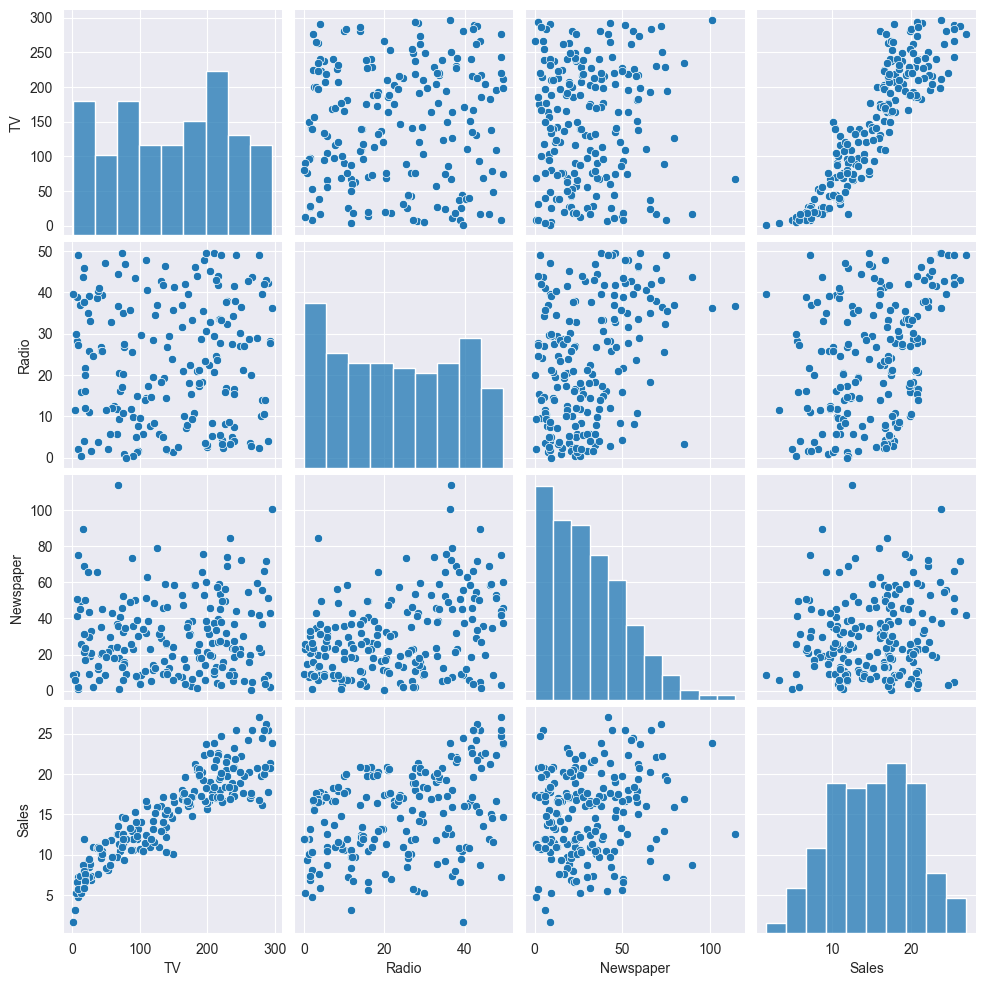

In [65]:
sns.pairplot(df);

In [66]:
class BayesianLinearRegression:
  def __init__(self, lam):
    self.lam = lam

  def fit(self, X, y):
    # Find the posterior p(w | X, y)
    N, D = X.shape

    # Naively use MLE to estimate sigma^2
    w_mle = np.linalg.solve(X.T @ X, X.T @ y)
    self.sigma_sq = np.mean((y - X @ w_mle)**2)

    # Posterior precision
    self.w_precision = self.lam * np.eye(D) + X.T @ X / self.sigma_sq
    self.w_mean = np.linalg.solve(self.w_precision, X.T @ y / self.sigma_sq)

  def predict(self, X):
    # Find the predictive posterior p(y^ | x^, X, y)

    N, D = X.shape
    predicted_mean = X @ self.w_mean

    # predicted_var = self.sigma_sq * np.ones(N)
    # for i in range(N):
    #   predicted_var[i] += X[i] @ np.linalg.solve(self.precision, X[i])

    # Vectorize method
    predicted_var = self.sigma_sq + \
      np.sum(X.T * np.linalg.solve(self.w_precision, X.T), axis=0)

    return predicted_mean, predicted_var

In [67]:
df['ones'] = 1

In [68]:
X = df[['TV', 'Radio', 'Newspaper', 'ones']].to_numpy()
y = df['Sales'].to_numpy()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [70]:
X_train.shape, y_train.shape

((134, 4), (134,))

In [71]:
bayes_model = BayesianLinearRegression(lam=0.7)
bayes_model.fit(X_train, y_train)

In [72]:
predicted_mean, predicted_var = bayes_model.predict(X_test)

In [73]:
def get_mse(t, y):
  return np.mean((t - y)**2)

In [74]:
get_mse(y_test, predicted_mean)

np.float64(2.685394774593529)

## Plot the posterior weights

In [75]:
bayes_model.w_mean

array([0.05509559, 0.10509985, 0.0108686 , 4.32489063])

In [76]:
cov = np.linalg.inv(bayes_model.w_precision)
cov

array([[ 2.98451588e-06, -1.82371140e-06, -9.35899549e-07,
        -3.89565164e-04],
       [-1.82371140e-06,  1.05968771e-04, -2.54396283e-05,
        -1.43760745e-03],
       [-9.35899549e-07, -2.54396283e-05,  5.38975065e-05,
        -8.83891620e-04],
       [-3.89565164e-04, -1.43760745e-03, -8.83891620e-04,
         1.40899040e-01]])

In [77]:
from scipy.stats import norm

m0 = bayes_model.w_mean[0]
m1 = bayes_model.w_mean[1]
m2 = bayes_model.w_mean[2]
s0 = np.sqrt(cov[0,0])
s1 = np.sqrt(cov[1,1])
s2 = np.sqrt(cov[2,2])
s0

np.float64(0.0017275751452808772)

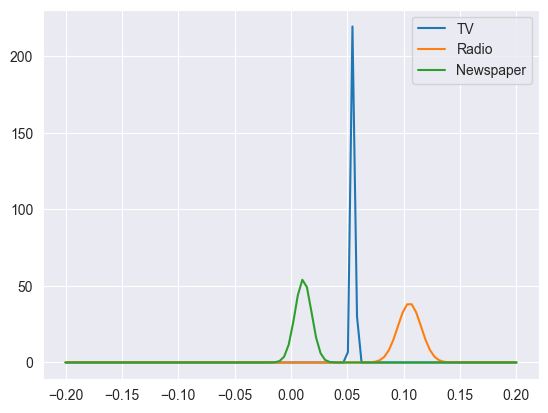

In [78]:
x_vals = np.linspace(-0.2, 0.2, 100)
y_vals = norm.pdf(x_vals, m0, s0)
plt.plot(x_vals, y_vals, label='TV')

y_vals = norm.pdf(x_vals, m1, s1)
plt.plot(x_vals, y_vals, label='Radio')

y_vals = norm.pdf(x_vals, m2, s2)
plt.plot(x_vals, y_vals, label='Newspaper')
plt.legend();

## Compare with frequentist regression

In [79]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     363.8
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           4.98e-63
Time:                        00:04:14   Log-Likelihood:                -258.48
No. Observations:                 134   AIC:                             525.0
Df Residuals:                     130   BIC:                             536.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0538      0.002     30.078      0.000       0.050       0.057
x2             0.1003      0.011      9.523      0.000       0.079       0.121
x3             0.0079      0.007      1.054      0.294      -0.007       0.023
const          4.7980      0.401     11.953      0.000       4.004       5.592
==============================================================================
Omnibus:                       13.479   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.202
Skew:                          -0.477   Prob(JB):                     1.51e-05
Kurtosis:                       4.751   Cond. No.                         496.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
predictions = res.get_prediction(X_test)

In [81]:
predictions

In [82]:
get_mse(y_test, predictions.predicted_mean)

np.float64(2.722866082025958)

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
model = LinearRegression()
model.fit(X_train, y_train)
p_test = model.predict(X_test)
get_mse(y_test, p_test)

np.float64(2.7228660820259654)

## Answering Business Questions with the Posterior Predictive
#### This final step demonstrates the key practical advantage of Bayesian regression over OLS. Instead of just getting a single-point prediction, we can quantify our uncertainty and answer complex questions about risk.
1. Define a Scenario: We created a hypothetical advertising budget:

In [85]:
tv = 200
radio = 30
newspaper = 50
X_new = np.array([[tv, radio, newspaper, 1]])
p_mean, p_var = bayes_model.predict(X_new)

2. Make a Probabilistic Prediction: We used our model's .predict() method. It returned two crucial values, defining an entire Normal distribution for the expected sales:

    * p_mean = 19.04: The most likely sales outcome. (An OLS model would stop here).

    * p_var = 2.82: The total variance (uncertainty) associated with this specific prediction.

In [86]:
p_mean, p_var

(array([19.04043361]), array([2.81649544]))

3. Calculate Risk: This allows us to answer a critical business question that OLS cannot:

    * "What is the probability that sales will be below 15?"

    * Using the Cumulative Distribution Function (norm.cdf), we calculate the area under our predictive bell curve to the left of the value 15.

In [94]:
result = norm.cdf(15, loc=p_mean, scale=np.sqrt(p_var))
result

array([0.00803021])

In [96]:
result_percentage = result * 100
print(f"Probability is: {result_percentage[0]:.2f}%")

Probability is: 0.80%


#### Conclusion: The model gives us an actionable insight: for this budget, there is only a 0.8% risk of sales falling below 15 units. This ability to calculate the probability of any outcome (e.g., "what's the chance we sell more than 22?") is the true power of this Bayesian model.

![](https://deeplearningcourses.com/notebooks_v3_pxl?sc=F6xKD0lmTSPLR2eDkH8vyg&n=Code)